# Resampling with Pyresample

This notebook will show overview of all the resampling methods in Pyresample.

Set some environment variables for performance tweaking

In [4]:
import os
os.environ['PYTROLL_CHUNK_SIZE'] = "1024"
os.environ['DASK_NUM_WORKERS'] = "4"
os.environ['OMP_NUM_THREADS'] = "1"

We'll use Satpy to read some data.

In [5]:
from satpy import Scene
from satpy.resample import get_area_def
import glob

fnames = glob.glob("/home/lahtinep/data/satellite/new/*201909031245*")
scn = Scene(reader='seviri_l1b_hrit', filenames=fnames)
scn.load([10.8])
data = scn[10.8]

 Get the source and target area definitions.

In [30]:
source_adef = data.attrs['area']
euro4_adef = get_area_def('euro4')

## Nearest neighbour resampling

Nerest neighbour is the most basic resampler Pyresample offers. As the name says, it'll pick value from the closest source location and place it in the target area.

Create the resampler, calculate the indices needed for resampling and resample the data to the target area. The `radius_of_influence` is used so that there are no gaps in the northern areas due to source data sparsity.

In [51]:
from pyresample.kd_tree import XArrayResamplerNN

resampler = XArrayResamplerNN(source_adef, euro4_adef, radius_of_influence=50e3)
resampler.get_neighbour_info()
res = resampler.get_sample_from_neighbour_info(data)

Compute the resampling and show the resulting image.

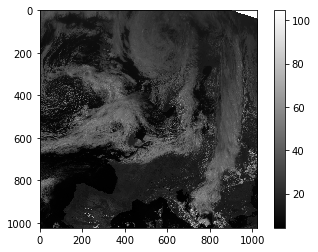

In [52]:
import matplotlib.pyplot as plt
res = res.compute()
plt.imshow(res, cmap='gray')
plt.colorbar()
plt.show()

And a small section from the north:

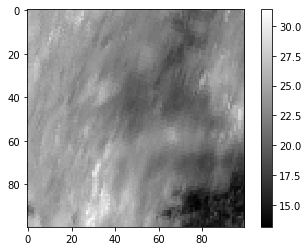

In [53]:
plt.imshow(res[:100, 500:600], cmap='gray')
plt.colorbar()
plt.show()

## Bilinear resampling

The nearest neighbour interpolation creates rough features near the edges of the geostationary disk. This can be counteracted by using bilinear intepolation, which creates smoother results.

NOTE: This is much slower than nearest neighbour resampling.

In [38]:
from pyresample.bilinear.xarr import XArrayResamplerBilinear

resampler = XArrayResamplerBilinear(source_adef, euro4_adef,
                                    radius_of_influence=50e3)
resampler.get_bil_info()
res = resampler.get_sample_from_bil_info(data)

/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/array/core.py:3914: RuntimeWarning: invalid value encountered in greater
  result = function(*args, **kwargs)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/array/core.py:3914: RuntimeWarning: invalid value encountered in less
  result = function(*args, **kwargs)


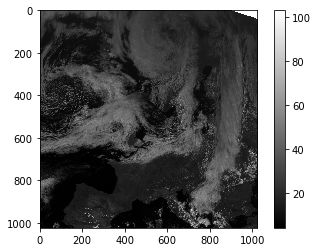

In [39]:
res = res.compute()
plt.imshow(res, cmap='gray')
plt.colorbar()
plt.show()

And the same crop we had for nearest neighbour:

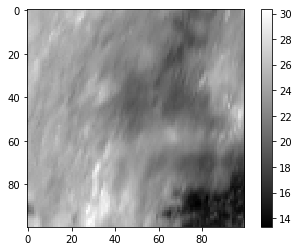

In [50]:
plt.imshow(res[:100, 500:600], cmap='gray')
plt.colorbar()
plt.show()

As we see, the result is much smoother.

## Bucket resamplers

The bucket resampling collects data into the closest target area pixels, or bins, or "buckets". Each source pixel can end up in only one pixel, fractional binning hasn't been (yet) implemented.

Load the higher resolution HRV channel for better coverage.

In [10]:
scn = Scene(reader='seviri_l1b_hrit', filenames=fnames)
scn.load(['HRV'])
data = scn['HRV']
source_adef = data.attrs['area']

/home/lahtinep/Software/pytroll/packages/pyresample/pyresample/geometry.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self.pixel_size_y = (area_extent[3] - area_extent[1]) / float(height)


Initialize the resampler with target area and source coordinates.

In [12]:
from pyresample.bucket import BucketResampler

lons, lats = source_adef.get_lonlats(chunks=1024)
resampler = BucketResampler(euro4_adef, lons, lats)

First, find out how many pixels fall in each of the target pixels. This can be used e.g. to create a density map of lightning data. The data in this example isn't very suitable to demonstrate the usage.

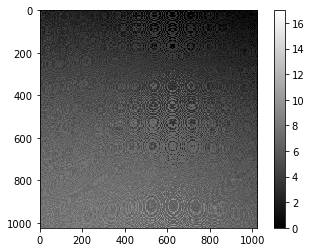

In [13]:
counts = resampler.get_count()
plt.imshow(counts, cmap='gray')
plt.colorbar()
plt.show()

The next example shows how to get the sum of all values in each of the target locations. One usecase would be to create the above mentioned lightning density plot from allready aggregated data, that is in some other projection and needs to be resampled.

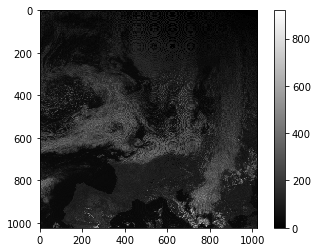

In [16]:
sums = resampler.get_sum(data)
plt.imshow(sums, cmap='gray')
plt.colorbar()
plt.show()

More usable example for the data we are handling is to average the values in each target location. This could be done basically by dividing the above two results, but it is better to use the built-in version that does some additional error checking.

The northern parts show nicely how the sparsity of the data at the edge of SEVIRI imaging area results in plenty of pixels without any data in them.

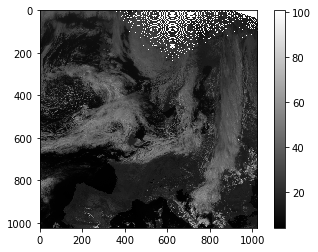

In [18]:
average = resampler.get_average(data)
plt.imshow(average, cmap='gray')
plt.colorbar()
plt.show()

The next bucket resampler is used to calculate the fractional occurences of categorical (integer) data in each bin. Value of `1.0` means all the values are from the category in question, while `0.0` means there were no hits. If there were no hits in any category (e.g. like in the north in this and previous examples) the value is `np.nan`.

Create categorical data from the HRV channel and calculate the fractions for a subset of the categories. The full per-category fractions can be retrieved by omitting `categories` keyword argument, or setting it to `None`. Omitting `categories` will require searching for the unique values from the array and slow down the processing, so it's better to always define them if known.

In [24]:
import numpy as np
# Digitize the data to nearest 20 reflectance units
data_int = 20. * (data / 20.).astype(np.uint8)
# Compute the fractions for categories 60, 80 and 100
fractions = resampler.get_fractions(data_int, categories=[60, 80, 100])
# Show which categories are available
fractions.keys()

dict_keys([60, 80, 100])

/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


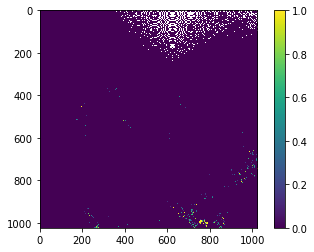

In [29]:
# Compute only 60 % reflectance fractions for viewing
fraction = fractions[60].compute()
plt.imshow(fraction)
plt.colorbar()
plt.show()